<a href="https://colab.research.google.com/github/HR-HBM/BENG_BME-Project/blob/main/ProjectPhase02(preprocessing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

# Function to apply Sobel Filter on RGB image (separate each channel)
def sobel_filter_rgb(input_image):
    # Ensure input image has 4 dimensions (batch size, height, width, channels)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension

    input_image = tf.cast(input_image, tf.float32)
    sobel_edges = tf.image.sobel_edges(input_image)

    # Combining the channels for visualization (average across channels)
    sobel_combined = tf.reduce_mean(sobel_edges, axis=-1)  # Take the average across RGB channels
    return sobel_combined[0].numpy()  # Remove batch dimension and return as NumPy array

# Function for Canny edge detection on each RGB channel
def canny_edge_rgb(input_image, low_threshold=100, high_threshold=200):

    input_image = input_image.astype(np.uint8)

    # Apply Canny on each channel (R, G, B)
    edges_r = cv2.Canny(input_image[:, :, 0], low_threshold, high_threshold)
    edges_g = cv2.Canny(input_image[:, :, 1], low_threshold, high_threshold)
    edges_b = cv2.Canny(input_image[:, :, 2], low_threshold, high_threshold)

    # Combine the edges for all channels (stack them together)
    edges_combined = np.stack([edges_r, edges_g, edges_b], axis=-1)

    return edges_combined

# Gabor filter creation function
def gabor_kernel(ksize, sigma, theta, lambd, gamma, psi):
    """Creates a Gabor kernel."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma
    nstds = 3
    xmax = max(abs(nstds * sigma_x), abs(nstds * sigma_y))
    xmin = -xmax
    ymin = xmin
    ymax = xmax
    (x, y) = np.meshgrid(np.linspace(xmin, xmax, ksize),
                         np.linspace(ymin, ymax, ksize))
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-0.5 * (rotx**2 / sigma_x**2 + roty**2 / sigma_y**2)) * \
         np.cos(2 * np.pi * rotx / lambd + psi)
    return gb

def apply_gabor_filter_rgb(input_image, kernel):
    """Applies the Gabor filter to an RGB image (channel-wise)."""

    # Ensure input image has 4 dimensions (batch size, height, width, channels)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension (shape becomes [1, H, W, 3])
    input_image = tf.cast(input_image, tf.float32)     # Ensure image is in float32 format

    # Ensure the kernel shape is compatible (5x5 filter with depth 1 for each channel)
    kernel = kernel[..., np.newaxis, np.newaxis]  # Add a new axis for channel dimension (shape becomes [5, 5, 1, 1])

    # Apply the Gabor filter to each channel (R, G, B)
    gabor_output_r = tf.nn.conv2d(input_image[:, :, :, 0:1], kernel, strides=[1, 1, 1, 1], padding='SAME')  # Red channel
    gabor_output_g = tf.nn.conv2d(input_image[:, :, :, 1:2], kernel, strides=[1, 1, 1, 1], padding='SAME')  # Green channel
    gabor_output_b = tf.nn.conv2d(input_image[:, :, :, 2:3], kernel, strides=[1, 1, 1, 1], padding='SAME')  # Blue channel

    # Combine the outputs for RGB channels
    gabor_combined = tf.concat([gabor_output_r[0, :, :, 0], gabor_output_g[0, :, :, 0], gabor_output_b[0, :, :, 0]], axis=-1)

    return gabor_combined.numpy()  # Convert the tensor to a NumPy array and return it

# Upload images to Colab
uploaded = files.upload()

# Function to load and preprocess the image
def load_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image file
    return image

# Load images from the uploaded files
image_paths = list(uploaded.keys())  # Get the list of image paths
num_images = len(image_paths)

# Prepare the plots to display results for 28 images
plt.figure(figsize=(15, 20))  # Adjust the figure size to fit the 4x7 grid

for idx, image_path in enumerate(image_paths[:7]):  # Limit to the first 7 images (originals)

    # Load the image
    img = load_image(image_path).numpy()  # Convert to NumPy array for visualization

    # Apply Sobel Filter (RGB)
    sobel_output = sobel_filter_rgb(img)

    # Apply Canny Edge Detection (RGB)
    canny_output = canny_edge_rgb(img)

    # Apply Gabor Filter (RGB)
    gabor_kernel_img = gabor_kernel(ksize=5, sigma=1.0, theta=np.pi/4, lambd=10.0, gamma=0.5, psi=0)
    gabor_output = apply_gabor_filter_rgb(img, gabor_kernel_img)

    # Display Original and Filtered images for comparison
    plt.subplot(4, 7, idx + 1)  # Original image
    plt.imshow(img)
    plt.title(f"Original {idx + 1}")
    plt.axis('off')

    # Display Sobel output
    plt.subplot(4, 7, idx + 1 + 7)  # Sobel image
    plt.imshow(sobel_output, cmap='gray')
    plt.title(f"Sobel {idx + 1}")
    plt.axis('off')

    # Display Canny output
    plt.subplot(4, 7, idx + 1 + 14)  # Canny image
    plt.imshow(canny_output)
    plt.title(f"Canny {idx + 1}")
    plt.axis('off')

    # Display Gabor output
    plt.subplot(4, 7, idx + 1 + 21)  # Gabor image
    plt.imshow(gabor_output)
    plt.title(f"Gabor {idx + 1}")
    plt.axis('off')

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

Saving 992.1.jpg to 992.1 (8).jpg
Saving 992.2.jpg to 992.2 (10).jpg
Saving 987.3.jpg to 987.3 (10).jpg
Saving 987.4.jpg to 987.4 (12).jpg
Saving 983.3.jpg to 983.3 (12).jpg
Saving 96.4.jpg to 96.4 (14).jpg
Saving 96.1.jpg to 96.1 (14).jpg


UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to float is not supported [Op:Cast] name: 

<Figure size 1500x2000 with 0 Axes>

Saving 96.4.jpg to 96.4 (13).jpg
Saving 96.1.jpg to 96.1 (13).jpg
Saving 96.2.jpg to 96.2 (12).jpg
Saving 96.3.jpg to 96.3 (12).jpg
Saving 954.3.jpg to 954.3 (12).jpg
Saving 954.4.jpg to 954.4 (8).jpg
Saving 936.1.jpg to 936.1 (8).jpg
Saving 936.3.jpg to 936.3 (7).jpg
Saving 936.4.jpg to 936.4 (5).jpg
Saving 919.3.jpg to 919.3 (4).jpg
Saving 919.4.jpg to 919.4 (4).jpg
Saving 913.1.jpg to 913.1 (4).jpg


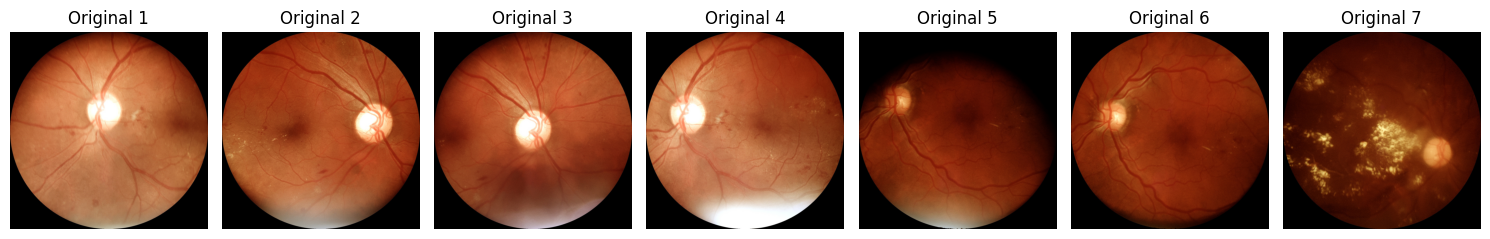

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
import PIL.Image as Image
import io

# Upload images to Colab
uploaded = files.upload()

# Convert uploaded keys to a list to allow slicing
uploaded_keys = list(uploaded.keys())

# Prepare to display images
plt.figure(figsize=(15, 10))

# Load and display the first 7 images
for idx, image_path in enumerate(uploaded_keys[:7]):  # Limit to the first 7 images
    img = Image.open(io.BytesIO(uploaded[image_path]))  # Open the image from the uploaded data

    # Display the image
    plt.subplot(2, 7, idx + 1)
    plt.imshow(img)  # Directly display the image with matplotlib
    plt.title(f"Original {idx + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving 1025.1_rotation15.jpg to 1025.1_rotation15.jpg


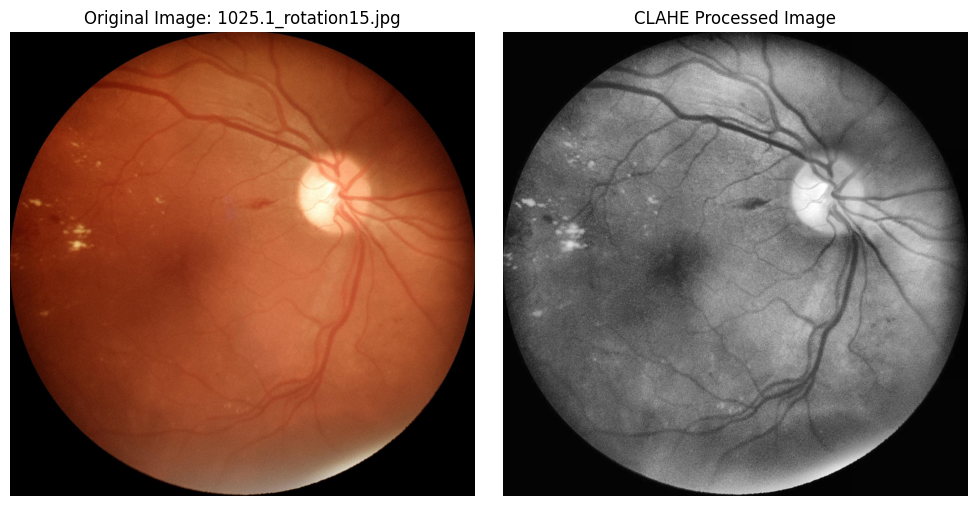

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
import PIL.Image

# Upload image(s) in Google Colab
uploaded_files = files.upload()

# Process each uploaded image
for file_name in uploaded_files.keys():
    # Read the uploaded image as an OpenCV image
    image_stream = BytesIO(uploaded_files[file_name])
    pil_image = PIL.Image.open(image_stream)
    original_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)  # Convert PIL to OpenCV BGR format

    # Convert to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)  # Apply CLAHE on grayscale image

    # Convert CLAHE grayscale image back to RGB
    clahe_rgb = cv2.merge([clahe_image, clahe_image, clahe_image])

    # Convert original image from BGR to RGB for correct display in Matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original and CLAHE-processed images
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image: {file_name}')
    plt.axis('off')

    # CLAHE-enhanced image
    plt.subplot(1, 2, 2)
    plt.imshow(clahe_rgb, cmap='gray')
    plt.title(f'CLAHE Processed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
print("Original Image Shape:", original_image.shape)  # Expected: (height, width, 3)
print("CLAHE Image Shape:", clahe_rgb.shape)  # Expected: (height, width, 3)


Original Image Shape: (1600, 1600, 3)
CLAHE Image Shape: (1600, 1600, 3)


Saving 588.4_rotation15_rotation30.jpg to 588.4_rotation15_rotation30 (1).jpg


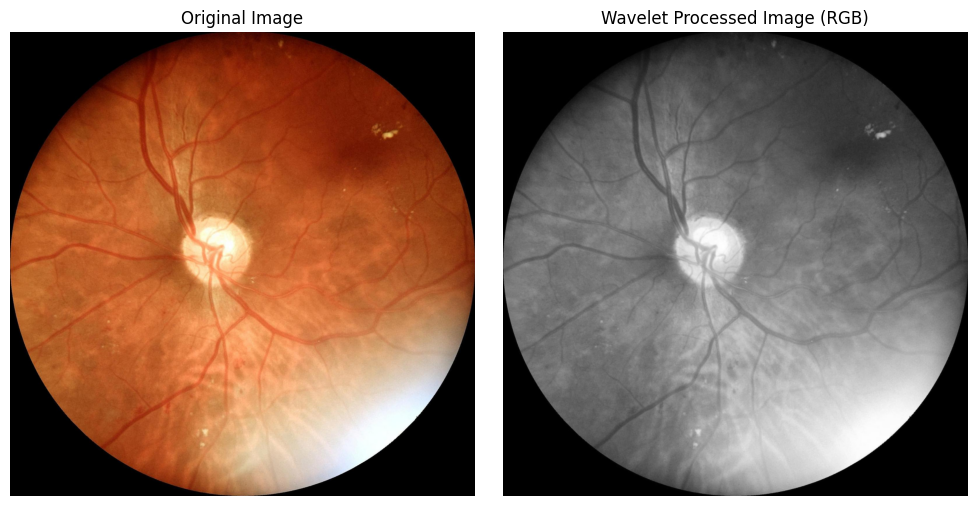

Original Image Shape: (1600, 1600, 3)
Wavelet Transformed Image Shape: (1600, 1600, 3)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Wavelet Transform Library
from google.colab import files
from PIL import Image

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the first uploaded file

# Load the image using OpenCV
original_image = cv2.imread(image_path)

# Convert from BGR to RGB for correct color display
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Function to apply Discrete Wavelet Transform (DWT)
def apply_wavelet_transform(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply 2D Discrete Wavelet Transform using Haar wavelet
    coeffs2 = pywt.dwt2(gray, 'haar')
    cA, (cH, cV, cD) = coeffs2  # Approximation, Horizontal, Vertical, Diagonal

    # Weighted reconstruction to enhance important details
    alpha = 0.8  # Weight for approximation coefficients (cA)
    beta = 0.2   # Weight for detail coefficients (cH, cV, cD)

    processed_image = pywt.idwt2((alpha * cA, (beta * cH, beta * cV, beta * cD)), 'haar')

    # Normalize to 8-bit range [0,255]
    processed_image = cv2.normalize(processed_image, None, 0, 255, cv2.NORM_MINMAX)
    processed_image = np.uint8(processed_image)

    # Convert back to 3-channel RGB to match model input format
    wavelet_rgb = cv2.merge([processed_image, processed_image, processed_image])

    return wavelet_rgb

# Apply Wavelet Transform
wavelet_image = apply_wavelet_transform(original_image)

# Display the original and processed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

# Wavelet Transformed Image
plt.subplot(1, 2, 2)
plt.imshow(wavelet_image)
plt.title('Wavelet Processed Image (RGB)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print image shapes to confirm correct processing
print("Original Image Shape:", original_image.shape)  # Expected: (height, width, 3)
print("Wavelet Transformed Image Shape:", wavelet_image.shape)  # Expected: (height, width, 3)


In [ ]:
!pip install PyWavelets
